# PAINTINGS RECOGNIZER CNN



In [1]:
#Import of the necessary libriries

from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import random
import urllib.request
import keras
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path
import time


from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard


!pip install tensorflow scikeras scikit-learn


from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from keras.utils import to_categorical
from keras.optimizers import Adam

import gc

import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\SAMI\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Data Gathering

We decide to develope the classifier over 4 different painters. The reason behind this is related to the complexity of processing large amount of pictures.

All the paints have been collected from the website
The painters we decided to www.wikiart.org.

The painters we decided to select are:

*   Pierre-Auguste Renoir
*   Vincent Van Gogh
*   Pablo Picasso
*   Claude Monet

We decided to pick this authors for the quality of the images, the amount of them. In addition we wanted to bring paintings from differents artistic waves.

For each paint not only the image has been collected but also information regarding the date, style, period, genre and materials and techniques.



All the paintings have been collected using the web scraping techique, then to each of them an unique code(author initial letters and a number, ex. Pablo Picasso, PP_1) has been assigned and the information about each painting saved in an excel file.

In [2]:
#Creating the dataset of the datails reagarding each paint

Painting_info=pd.DataFrame(columns=["ID","TITLE","AUTHOR","DATE","STYLE","PERIOD","GENRE","MEDIA"])

#Painting_info=pd.read_excel(r"C:\Users\SAMI\Desktop\ai projet\Images/info.xlsx")

Painting_info=Painting_info.set_index("ID")

In [3]:
# Web scraping code
# Parameters
#Dictionary of the painters and the corresponding web link to the list of their paintings
targets={"Pablo Picasso":"https://www.wikiart.org/en/pablo-picasso/all-works/text-list","Claude Monet":"https://www.wikiart.org/en/claude-monet/all-works/text-list","Vincent Van Gogh":"https://www.wikiart.org/en/vincent-van-gogh/all-works/text-list","Pierre-Auguste Renoir":"https://www.wikiart.org/en/pierre-auguste-renoir/all-works/text-list"}

# Dictionary of the dataset columns and the corresponding section in a painting web page
informations={"DATE":"Date:","STYLE":"Style:","PERIOD":"Period:","GENRE":"Genre:","MEDIA":"Media:"} #Not required to be changed

#---------------------------
Missing_images=[]

data_gathering=True #Set True to allowed the web scraping

def info_collection(author,title,LINK,ID): # This function collectes the information(image included) for each image saving the image in the painter's folder and the information in the dataset

    Painting_info.loc[ID,"TITLE"]=title
    Painting_info.loc[ID,"AUTHOR"]=author
    Painting_info.loc[ID,"FLAG"]=1

    link_fin="https://www.wikiart.org%s"%(LINK)
    print(link_fin)
    page=requests.get(link_fin)
    soup = BeautifulSoup(page.content, 'html.parser')
    warning = soup.find_all('li')

    for i in warning:
      if i.find('s')!= None:
        for d in informations.keys():
          if i.find('s').text==informations[d]:
            info=i.find('span').text if informations[d]=="Date:" or informations[d]=="Media:" else i.find('a').text
            Painting_info.loc[ID,d]=info
    Painting_info.loc[ID,"INFO"]=link_fin

    try:
      urllib.request.urlretrieve(soup.find_all('img',{"itemprop":"image"})[0].attrs['src'],r"Images\%s/%s.jpg"%(str(author),ID)) #Required that a folder with the author name is created the folder Images
    except:
      Missing_images.append(ID)

def list_paintings(link,author): # This function collect the web link for each paintigs of an author and creats for each an ID. Then this information are passed to the info_collection function
  page=requests.get(link)
  soup = BeautifulSoup(page.content, 'html.parser')
  sections=soup.find_all('ul',{"class":"painting-list-text"})
  pictures=sections[0].find_all("a")
  count=1
  stato=0
  tot=0
  for i in pictures:
    tot=len(list(pictures))
    print("%s:%s/%s"%(author,stato,tot))
    ID="%s%s_%s"%(author.split(" ")[0][0],author.split(" ")[1][0],str(count))
    info_collection(author,i.text,i.attrs['href'],ID)
    count=count+1

if data_gathering==True:
  for name in targets.keys(): # For each author is the dictionary targets the list_paintigs function is applied.
    list_paintings(targets[name],name)

  #Data cleaning
  Painting_info.loc[:,"MEDIA"]=Painting_info.loc[:,"MEDIA"].apply(lambda x: str(x).replace("\n",""))
  Painting_info.loc[:,"DATE"]=Painting_info.loc[:,"DATE"].apply(lambda x: str(x).split(";")[0])
  #The dataset with the information is saved as an excel file
  Painting_info.to_excel(r"Images\info.xsl")
  #In same occasion the algorithm is not able to collect the image of the paintings. In these cases the painting ID is saved in a special csv file
  Painting_info.loc[Missing_images,:].to_csv(r"Images\Missing_Images.csv")




Pablo Picasso:0/1170
https://www.wikiart.org/en/pablo-picasso/the-picador-1890
Pablo Picasso:0/1170
https://www.wikiart.org/en/pablo-picasso/house-in-the-field-1893


KeyboardInterrupt: 

In this section a more detailed explaination of the web scraping code is given.

The code is composed by two functions and some line of code throught wich some data cleaning is done and the information are saved.

The two functions consiust in: a function, list_paintings, wich collects all the web link to all the painters of a painter and create the ID key . Then the second function, info_collection, gatehers the data from the painting's page and save them in the dataset.

In [ ]:
# The following code permits to get the image of a painiting manually. It is used for the paintings in the Missing_Images csv file.

#Manual image dowload
#adress="https://uploads8.wikiart.org/images/claude-monet/christmas-roses.jpg!Large.jpg"
#ID="CM_608"
#urllib.request.urlretrieve(adress,"/content/drive/MyDrive/AI project /Images/Claude Monet/%s.jpg"%(ID))

During the process of choosing wich painters would have been the best for our model,according with the availability of images and their quality, many paintings have been downloaded. In the following dataset is possible to see all of them.

In [ ]:
#Dataset of the collected images
Painting_info

,TITLE,AUTHOR,DATE,STYLE,PERIOD,GENRE,INFO,MEDIA,FLAG
ID,,,,,,,,,
PP_1,The picador,Pablo Picasso,1890,Post-Impressionism,Early Years,genre painting,https://www.wikiart.org/en/pablo-picasso/the-p...,NaN,1
PP_2,House in the field,Pablo Picasso,1893,Post-Impressionism,Early Years,landscape,https://www.wikiart.org/en/pablo-picasso/house...,"oil,canvas",1
PP_3,Plaster male torso,Pablo Picasso,1893,Realism,Early Years,sketch and study,https://www.wikiart.org/en/pablo-picasso/plast...,NaN,0
PP_4,Academical study,Pablo Picasso,1895,Realism,Early Years,nude painting (nu),https://www.wikiart.org/en/pablo-picasso/acade...,"oil,canvas",1
PP_5,Bust of young man,Pablo Picasso,1895,Realism,Early Years,portrait,https://www.wikiart.org/en/pablo-picasso/bust-...,"oil,canvas",1
...,...,...,...,...,...,...,...,...,...
WT_241,Venice,William Turner,NaN,Romanticism,NaN,cityscape,https://www.wikiart.org/en/william-turner/venedig,"oil,canvas",1
WT_242,View of Saint Germain en Laye and its Chateau,William Turner,NaN,Romanticism,NaN,landscape,https://www.wikiart.org/en/william-turner/view...,"watercolor,paper",1
WT_243,Welsh Bridge at Shrewsbury,William Turner,NaN,Romanticism,NaN,cityscape,https://www.wikiart.org/en/william-turner/wels...,"watercolor,paper",1


Quick overview of some dimensions:



*   INFO: web link to the wikiart painting's web page
*   FLAG: 1 if the image is in the imges database, 0 otherwise


##MONET VS PICASSO

Before starting with all the painters we have preferred to construct the CNN for only two of them, Monet and Picasso. These two painters present differences in the style that make the construction of the model easier.

### Data Exploration and Cleaning

In [ ]:
#Parameters

DATADIR = "Images"
CATEGORIES = ['Claude Monet', 'Pablo Picasso','Pierre-Auguste Renoir','Vincent Van Gogh']

In [ ]:
# Dataset Monet and Picasso

Painting_info.loc[Painting_info.loc[:,"AUTHOR"].isin(CATEGORIES),:].drop(["FLAG"],axis=1)

,TITLE,AUTHOR,DATE,STYLE,PERIOD,GENRE,INFO,MEDIA
ID,,,,,,,,
PP_1,The picador,Pablo Picasso,1890,Post-Impressionism,Early Years,genre painting,https://www.wikiart.org/en/pablo-picasso/the-p...,NaN
PP_2,House in the field,Pablo Picasso,1893,Post-Impressionism,Early Years,landscape,https://www.wikiart.org/en/pablo-picasso/house...,"oil,canvas"
PP_3,Plaster male torso,Pablo Picasso,1893,Realism,Early Years,sketch and study,https://www.wikiart.org/en/pablo-picasso/plast...,NaN
PP_4,Academical study,Pablo Picasso,1895,Realism,Early Years,nude painting (nu),https://www.wikiart.org/en/pablo-picasso/acade...,"oil,canvas"
PP_5,Bust of young man,Pablo Picasso,1895,Realism,Early Years,portrait,https://www.wikiart.org/en/pablo-picasso/bust-...,"oil,canvas"
...,...,...,...,...,...,...,...,...
PR_1408,Young Woman Reading,Pierre-Auguste Renoir,NaN,Impressionism,NaN,genre painting,https://www.wikiart.org/en/pierre-auguste-reno...,"oil,canvas"
PR_1409,Young Woman Seated in a Rowboat,Pierre-Auguste Renoir,NaN,Impressionism,NaN,genre painting,https://www.wikiart.org/en/pierre-auguste-reno...,"oil,canvas"
PR_1410,Young Woman Taking a Walk,Pierre-Auguste Renoir,NaN,Impressionism,NaN,portrait,https://www.wikiart.org/en/pierre-auguste-reno...,"oil,canvas"


/content/drive/MyDrive/AI project /Images/Claude Monet/CM_355.jpg


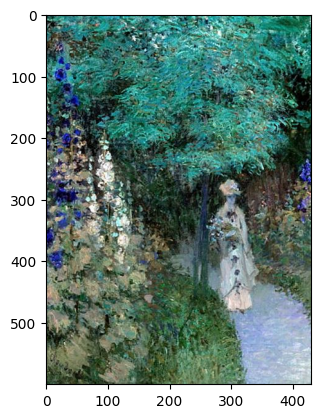

In [ ]:
# We want to check what an image look like
for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    img_array_ex = cv2.imread(os.path.join(path,img))
    print(os.path.join(path,img))
    plt.imshow(img_array_ex)
    plt.show
    break
  break

In [ ]:
print(img_array_ex.shape)

(600, 430, 3)


The problem we have in the data is that all the images have different sizes, so we need to reshape all the images.

In order to keep the highest level of image detail, we analyse all the images in the dataset looking for their size.

Then we save the lowest size and use it to reshape all the images

In [ ]:
#Desired minimum shape

Desire_shape=200

#Checking for the minimum hight and weight. In addition the alghoritm gives an idea of the distribution of the images in relation to the desired minimum shape


Shape_hight_min=0
image_h=""
Shape_wight_min=0
image_w=""
count=0

size_h={"-%s"%(Desire_shape):[0,[]],"+%s"%(Desire_shape):[0,[]]}
size_w={"-%s" %(Desire_shape):[0,[]],"+%s"%(Desire_shape):[0,[]]}



for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img))
    try:
      if count==0:
        Shape_hight_min=img_array.shape[1]
        Shape_wight_min=img_array.shape[0]
      if img_array.shape[1]<Shape_hight_min:
        Shape_hight_min=img_array.shape[1]
        image_h=img
      if img_array.shape[0]<Shape_wight_min:
        Shape_wight_min=img_array.shape[0]
        image_w=img
      if img_array.shape[1]<Desire_shape:
        size_h["-%s"%(Desire_shape)][0]=size_h["-%s"%(Desire_shape)][0]+1
        size_h["-%s"%(Desire_shape)][1].append(img)
      else:
        size_h["+%s"%(Desire_shape)][0]=size_h["+%s"%(Desire_shape)][0]+1
      if img_array.shape[0]<Desire_shape:
        size_w["-%s"%(Desire_shape)][0]=size_w["-%s"%(Desire_shape)][0]+1
        size_w["-%s"%(Desire_shape)][1].append(img)
      else:
        size_w["+%s"%(Desire_shape)][0]=size_w["+%s"%(Desire_shape)][0]+1
    except:
      print(img)
      count=count+1
      continue
    count=count+1

#Attention. The the weight and the hight could not be from the same image

size_min=(Shape_wight_min,Shape_hight_min)

image=(image_w,image_h)

print(size_min)

print(image)

print(size_w,size_h)

PP_1097.jpg
PP_1106.jpg
(228, 221)
('PR_346.jpg', 'PR_164.jpg')
{'-200': [0, []], '+200': [5021, []]} {'-200': [0, []], '+200': [5021, []]}


It is possible to see that all the images have both the sizes higher than 200. In order to make the classification process not too time consuming and in order to follow the idea that a resized image can be better than a high quality one, we have decided to rashape all the image as 210x210

In [ ]:
IMG_SIZE=210

<function matplotlib.pyplot.show(close=None, block=None)>

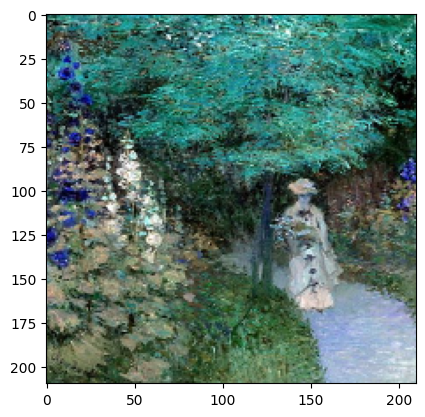

In [ ]:
# Example image reshaped
new_array = cv2.resize(img_array_ex,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array)
plt.show

As you can see in the image above, after reshaping the data, it is still visible and recognizable.

Looking trhorught the dowloaded images it is possible to see that not everyone can be used as dataset for our pourpose. Some of them are too small, some present low quality and others would make the leraning process difficults.

A selection of the image has been done, in the following dataset only the paintings considered "good" are shown.

In [ ]:
#Cleaned dataset
Painting_info.loc[(Painting_info.loc[:,"AUTHOR"].isin(CATEGORIES)) & (Painting_info.loc[:,"FLAG"]==1),:].drop(["FLAG"],axis=1)


,TITLE,AUTHOR,DATE,STYLE,PERIOD,GENRE,INFO,MEDIA
ID,,,,,,,,
PP_1,The picador,Pablo Picasso,1890,Post-Impressionism,Early Years,genre painting,https://www.wikiart.org/en/pablo-picasso/the-p...,NaN
PP_2,House in the field,Pablo Picasso,1893,Post-Impressionism,Early Years,landscape,https://www.wikiart.org/en/pablo-picasso/house...,"oil,canvas"
PP_4,Academical study,Pablo Picasso,1895,Realism,Early Years,nude painting (nu),https://www.wikiart.org/en/pablo-picasso/acade...,"oil,canvas"
PP_5,Bust of young man,Pablo Picasso,1895,Realism,Early Years,portrait,https://www.wikiart.org/en/pablo-picasso/bust-...,"oil,canvas"
PP_6,Female nude from back,Pablo Picasso,1895,Realism,Early Years,nude painting (nu),https://www.wikiart.org/en/pablo-picasso/femal...,"oil,canvas"
...,...,...,...,...,...,...,...,...
PR_1407,Young Woman in a Straw Hat,Pierre-Auguste Renoir,NaN,Impressionism,NaN,portrait,https://www.wikiart.org/en/pierre-auguste-reno...,"oil,canvas"
PR_1408,Young Woman Reading,Pierre-Auguste Renoir,NaN,Impressionism,NaN,genre painting,https://www.wikiart.org/en/pierre-auguste-reno...,"oil,canvas"
PR_1409,Young Woman Seated in a Rowboat,Pierre-Auguste Renoir,NaN,Impressionism,NaN,genre painting,https://www.wikiart.org/en/pierre-auguste-reno...,"oil,canvas"


In [ ]:
#Removed paintings

removed_paint_db=Painting_info.loc[(Painting_info.loc[:,"AUTHOR"].isin(CATEGORIES)) & (Painting_info.loc[:,"FLAG"]==0),:].drop(["FLAG"],axis=1)
removed_paint_db

,TITLE,AUTHOR,DATE,STYLE,PERIOD,GENRE,INFO,MEDIA
ID,,,,,,,,
PP_3,Plaster male torso,Pablo Picasso,1893,Realism,Early Years,sketch and study,https://www.wikiart.org/en/pablo-picasso/plast...,NaN
PP_19,"Advertisement for tavern ""Four cats""",Pablo Picasso,1897,Art Nouveau (Modern),Early Years,advertisement,https://www.wikiart.org/en/pablo-picasso/adver...,NaN
PP_23,La chata,Pablo Picasso,1899,Expressionism,Early Years,portrait,https://www.wikiart.org/en/pablo-picasso/la-ch...,"charcoal,gouache,watercolor,paper"
PP_37,Self-Portrait,Pablo Picasso,1900,Realism,Early Years,self-portrait,https://www.wikiart.org/en/pablo-picasso/self-...,"charcoal,paper"
PP_41,The cries of virgins,Pablo Picasso,1900,Art Nouveau (Modern),Early Years,nude painting (nu),https://www.wikiart.org/en/pablo-picasso/the-c...,"charcoal,paper"
...,...,...,...,...,...,...,...,...
PR_1395,Woman Standing by a Tree,Pierre-Auguste Renoir,NaN,Impressionism,NaN,genre painting,https://www.wikiart.org/en/pierre-auguste-reno...,NaN
PR_1397,Woman with a Muff,Pierre-Auguste Renoir,NaN,Impressionism,NaN,sketch and study,https://www.wikiart.org/en/pierre-auguste-reno...,NaN
PR_1404,Young Girl in a Blue Corset,Pierre-Auguste Renoir,NaN,Impressionism,NaN,portrait,https://www.wikiart.org/en/pierre-auguste-reno...,NaN


TypeError: ignored

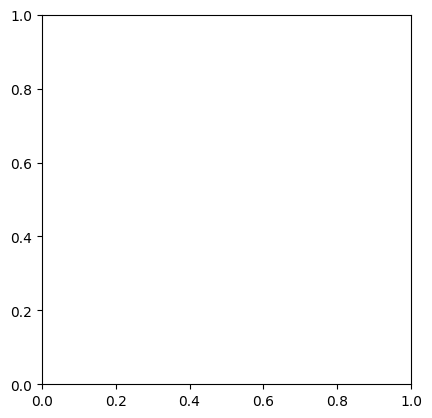

In [ ]:

#Example of a removed image

DATADIR="Images/Removed_images"

for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in removed_paint_db.loc[removed_paint_db.loc[:,"AUTHOR"]==category,:].index.values:
    img_array_ex = cv2.imread(os.path.join(path,img+".jpg"))
    plt.imshow(img_array_ex)
    plt.show
    print(img_array_ex.shape)
    break
  break



P.S

All the images that are removed from the dataset are collected inside the folder "removed_images"

###Data Prepocessing

The first step is to get all the images for each painters and trasform them in an array and then reshape them.

In [ ]:
X=[]
y=[]
def create_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)  # create path to Claude Monet and Pablo Picasso
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=Claude Monet 1=Pablo Picasso
        print("%s:%s"%(class_num,CATEGORIES[class_num]))
        for img in tqdm(os.listdir(path)):  # iterate over each image per Claude Monet and Pablo Picasso
          try:
            img_array = cv2.imread(os.path.join(path,img))  # convert to array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            X.append(new_array)
            y.append(class_num)
          except Exception as e:  # in the interest in keeping the output clean...
              pass

create_data()
print(len(X))

0:Claude Monet


100%|██████████| 1353/1353 [00:12<00:00, 111.47it/s]


1:Pablo Picasso


100%|██████████| 1061/1061 [00:06<00:00, 159.14it/s]


2:Pierre-Auguste Renoir


100%|██████████| 1398/1398 [00:10<00:00, 131.71it/s]


3:Vincent Van Gogh


100%|██████████| 1211/1211 [00:09<00:00, 127.00it/s]

5021


The step after is to determine a training and a test dataset

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.20,random_state=42)

In [ ]:
# The two dataset are trsformaed in array and normalized

def array_con(X_data,y_data):
  X_data = np.array(X_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y_data = np.array(y_data)
  #The X and y need to be an array
  X_data = X_data/255.0
  #The maximum number is 255, since we need to normalize data, it suffices to divide everything by 255
  return X_data,y_data

X_train,y_train=array_con(X_train,y_train)
X_test,y_test=array_con(X_test,y_test)

### Model Creation

A CNN is characterized by the presence of at a least a convolutional layer, a flatten one and an output one, rapresented by a dense layer.
Startinting from this idea, many variation can be set changing the number or the size of each layer or adding other type of layers like droupout ones.
The best way to create and optimize a model is then trying diffent combination using as discriminants the obtained accuracy values on the training and validation datasets.

In the following code is possible to see all the different combination we have tried to set the model architecture.

In the construction of a model very important are also the activation functions of the layers,the loss function and the optimization function. For the construction of the model it has been decided to go for:


*   **RELU** function for the convolutional and desne layers
*   **SIGMOID** function for the output layer
*   **BINARY CROSS ENTROPY** function as loss function
*   **ADAM** function as optimization function

In [ ]:
'''dense_layers = [0, 1, 2, 3]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3, 4]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=20,
                      validation_split=0.3,
                      callbacks=[tensorboard])'''

'dense_layers = [0, 1, 2, 3]\nlayer_sizes = [32, 64, 128]\nconv_layers = [1, 2, 3, 4]\n\nfor dense_layer in dense_layers:\n    for layer_size in layer_sizes:\n        for conv_layer in conv_layers:\n            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))\n            print(NAME)\n\n            model = Sequential()\n\n            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))\n            model.add(Activation(\'relu\'))\n            model.add(MaxPooling2D(pool_size=(2, 2)))\n\n            for l in range(conv_layer-1):\n                model.add(Conv2D(layer_size, (3, 3)))\n                model.add(Activation(\'relu\'))\n                model.add(MaxPooling2D(pool_size=(2, 2)))\n\n            model.add(Flatten())\n\n            for _ in range(dense_layer):\n                model.add(Dense(layer_size))\n                model.add(Activation(\'relu\'))\n\n            model.add(Dense(1))\n            model.add(Activatio

After doing all of these different models, We are left with these graphs that are obtained thanks to tenserflow

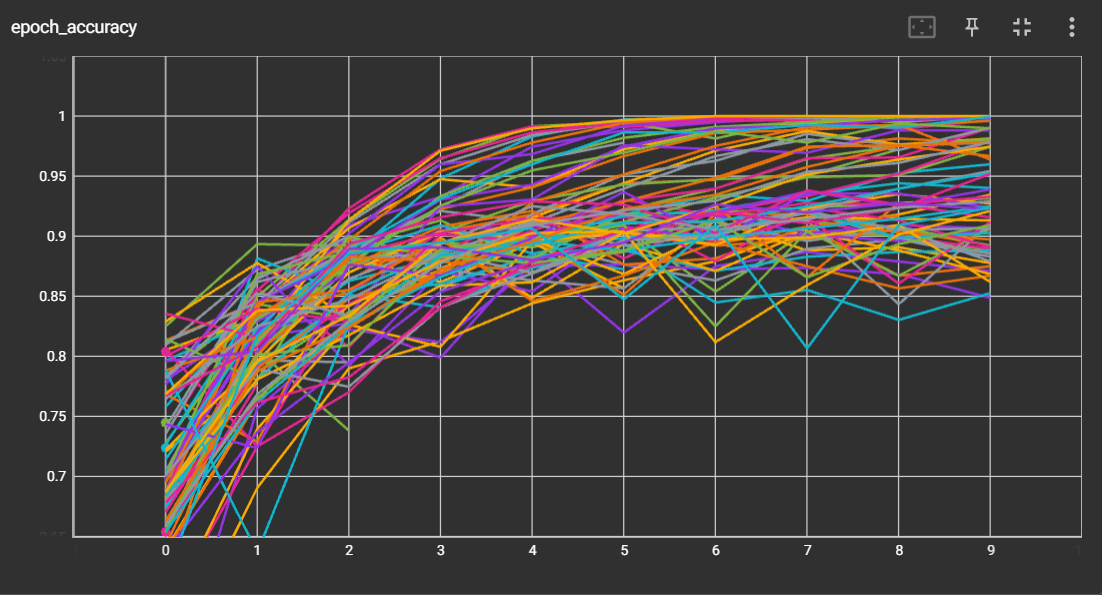

In the graph above, we can see all of the model made, This graph reflects the accuracy of our model on the training data, but this doesn't mean much for us because having accuracy of 1 is always proof of overfitting, so let's focus our attention on the validation loss.

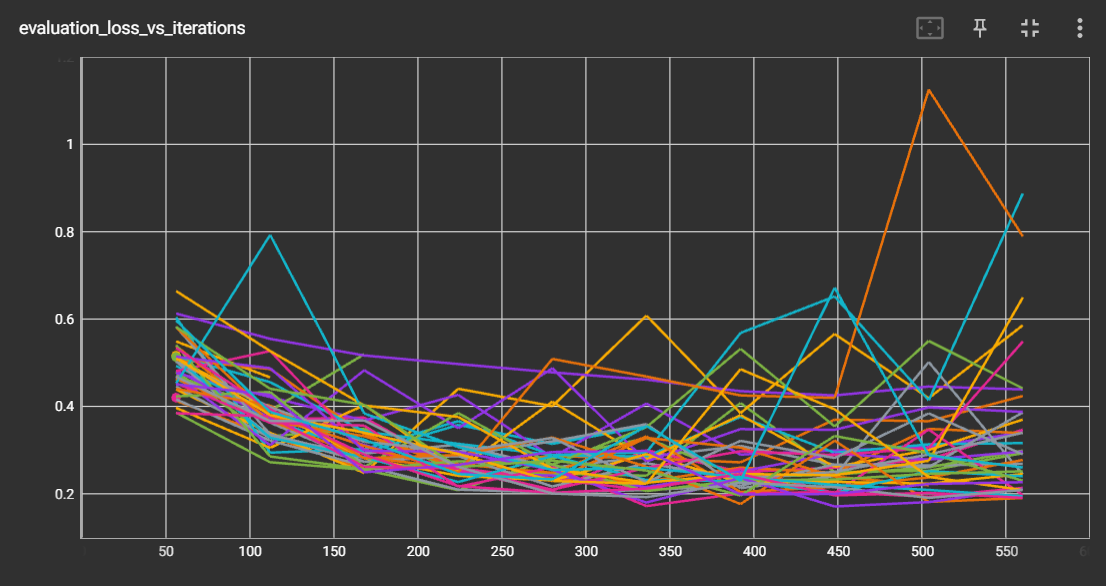

The graph above shows us the evaluation loss of each model and the number of epochs. after some tweaking of the graph it is clear that the model that performed best is the one with 3 convolutionals layers, 128 nodes and 0 dense layers.

In [ ]:
dense_layers = [0]
layer_sizes = [128]
conv_layers = [3]

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for l in range(3-1):
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

for _ in range(0):
  model.add(Dense(128))
  model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))



model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          validation_split=0.3)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We notice that the right number of epochs is 5, afterwards, the model starts overfitting.

Final model

In [ ]:
dense_layers = [0]
layer_sizes = [128]
conv_layers = [3]

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

for l in range(3-1):
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

for _ in range(0):
  model.add(Dense(128))
  model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))



model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

optimal_model = model.fit(X_train, y_train,
          batch_size=32,
          epochs=5,
          validation_split=0.3)

In [ ]:
prediction = model.predict(X_test)

### Model evaluation

Before starting the model evaluation it is interesting to have an overview of the final model architecture.

In [ ]:
model.summary()

The first step to evaluete a model is to check its accuracy.

From the section above we can see than the model present:


*   ACCURACY ON TRAINING DATA: ....
*   ACCURACY ON VALIDATION DATA: ....



In order to analyse the preformance of the model, it is necessary to evaluate it using data never seen before.

In [ ]:

evaluation = model.evaluate(X_test, y_test)

It is possible to see that the model present an ACCURACY ON TEST DATA of ....

Another importat step in order to evaluete a model is to analyse its confusion matrix, getting an idea of wich class it tends to mispredicts the label.

In [ ]:
# Since the class predictions are supplied in the form of probability that a label is 1, it is necessary to trasform them in a label.
#In order to this a threshold of 0.5 is used.

def convert_value(value):
    if value > 0.5:
        return 1
    else:
        return 0
y_pred = []
for i in prediction:
  y_pred.append(convert_value(i))
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique classes
classes = np.unique(np.concatenate((y_test, y_pred)))

# Create a figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Create the heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)  # Set tick labels based on unique classes
ax.yaxis.set_ticklabels(classes)  # Set tick labels based on unique classes

# Rotate tick labels if needed
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Adjust layout to make room for tick labels
plt.tight_layout()

# Display the plot
plt.show()

P.S

0=Claude Monet
1=Pablo Picasso

From the confusion matrix some interesting metrics can be conputed.

In [ ]:
print(classification_report(y_pred,y_test))

Another interesting analysis of the model can be done by observing the mispredicted images. This analysis can be particular interesting during the model construction process.

In [ ]:
mispredictions=y_pred!=y_test

for i in X_test[mispredictions]:
  plt.imshow(i)
  plt.axis('off')
  plt.show()


##4 AUTHORS

We have seen that it is possible to create a CNN that classifies the pantings with a quite good level of accuracy. So it is now time to implement a model that could recognise up to 4 painters: *Claude Monet, Pablo Picasso, Pierre-Auguste Renoir* and *Vincent Van Gogh*

### Data Exploration and Cleaning

In [ ]:
#Parameters

DATADIR = "Images"
CATEGORIES = ['Vincent Van Gogh','Claude Monet','Pablo Picasso','Pierre-Auguste Renoir']

In [ ]:
Painting_info.loc[Painting_info.loc[:,"AUTHOR"].isin(CATEGORIES),:].drop(["FLAG"],axis=1)

In [ ]:
#Desired minimum shape

Desire_shape=200

#Checking for the minimum hight and weight. In addition the alghoritm gives an idea of the distribution of the images in relation to the desired minimum shape


Shape_hight_min=0
image_h=""
Shape_wight_min=0
image_w=""
count=0

size_h={"-%s"%(Desire_shape):[0,[]],"+%s"%(Desire_shape):[0,[]]}
size_w={"-%s" %(Desire_shape):[0,[]],"+%s"%(Desire_shape):[0,[]]}



for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img))
    try:
      if count==0:
        Shape_hight_min=img_array.shape[1]
        Shape_wight_min=img_array.shape[0]
      if img_array.shape[1]<Shape_hight_min:
        Shape_hight_min=img_array.shape[1]
        image_h=img
      if img_array.shape[0]<Shape_wight_min:
        Shape_wight_min=img_array.shape[0]
        image_w=img
      if img_array.shape[1]<Desire_shape:
        size_h["-%s"%(Desire_shape)][0]=size_h["-%s"%(Desire_shape)][0]+1
        size_h["-%s"%(Desire_shape)][1].append(img)
      else:
        size_h["+%s"%(Desire_shape)][0]=size_h["+%s"%(Desire_shape)][0]+1
      if img_array.shape[0]<Desire_shape:
        size_w["-%s"%(Desire_shape)][0]=size_w["-%s"%(Desire_shape)][0]+1
        size_w["-%s"%(Desire_shape)][1].append(img)
      else:
        size_w["+%s"%(Desire_shape)][0]=size_w["+%s"%(Desire_shape)][0]+1
    except:
      print(img)
      count=count+1
      continue
    count=count+1

#Attention. The the weight and the hight could not be from the same image

size_min=(Shape_wight_min,Shape_hight_min)

image=(image_w,image_h)

print(size_min)

print(image)

print(size_w,size_h)

In [ ]:
IMG_SIZE= 220
#min(size_min)
print(IMG_SIZE)

In [ ]:
#Cleaned dataset
Painting_info.loc[(Painting_info.loc[:,"AUTHOR"].isin(CATEGORIES)) & (Painting_info.loc[:,"FLAG"]==1),:].drop(["FLAG"],axis=1)

In [ ]:
#Removed paintings

removed_paint_db=Painting_info.loc[(Painting_info.loc[:,"AUTHOR"].isin(CATEGORIES)) & (Painting_info.loc[:,"FLAG"]==0),:].drop(["FLAG"],axis=1)
removed_paint_db

In [ ]:
#Example of a removed image

DATADIR="Images/Removed_images"

for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in removed_paint_db.loc[removed_paint_db.loc[:,"AUTHOR"]==category,:].index.values:
    img_array_ex = cv2.imread(os.path.join(path,img+".jpg"))
    plt.imshow(img_array_ex)
    plt.show
    print(img_array_ex.shape)
    break
  break

P.S

All the images that are removed from the dataset are collected inside the folder "removed_images"

###Data Preprocessing

The first step is to get all the images for each painters and trasform them in an array and then reshape them.

In [ ]:
X=[]
y=[]

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)  # create path
        class_num = CATEGORIES.index(category)  # get the classification
        print("%s:%s"%(class_num,CATEGORIES[class_num]))
        for img in tqdm(os.listdir(path)):  # iterate over each image
          try:
            img_array = cv2.imread(os.path.join(path,img))  # convert to array
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
            X.append(new_array)
            y.append(class_num)
          except Exception as e:  # in the interest in keeping the output clean...
              pass

create_training_data()
print(len(X))

The class's labels are:


*   0 : Vincent Van Gogh
*   1 : Claude Monet
*   2 : Pablo Picasso
*   3 : Pierre-Auguste Renoir





In [ ]:
#The data are split in trainining and test data

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.20,random_state=44)

In [ ]:
# The two dataset are trsformaed in array and normalized

def array_con(X_data,y_data):
  X_data = np.array(X_data).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
  y_data = np.array(y_data)
  #The X and y need to be an array
  X_data = X_data/255.0
  #The maximum number is 255, since we need to normalize data, it suffices to divide everything by 255
  return X_data,y_data

X_train,y_train=array_con(X_train,y_train)
X_test,y_test=array_con(X_test,y_test)


###Model Creation

In [ ]:


dense_layers = [0,1,2,3]
layer_sizes = [32,64,128,256]
conv_layers = [3,4]


for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(len(CATEGORIES)))
            model.add(Activation('softmax'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='sparse_categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

            model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=20,
                      validation_split=0.3,
                      callbacks=[tensorboard])

To figure out the best model out of all these models, we need to chech the metrics and focus on the validation loss.

But first let's check the accuracy of the models.


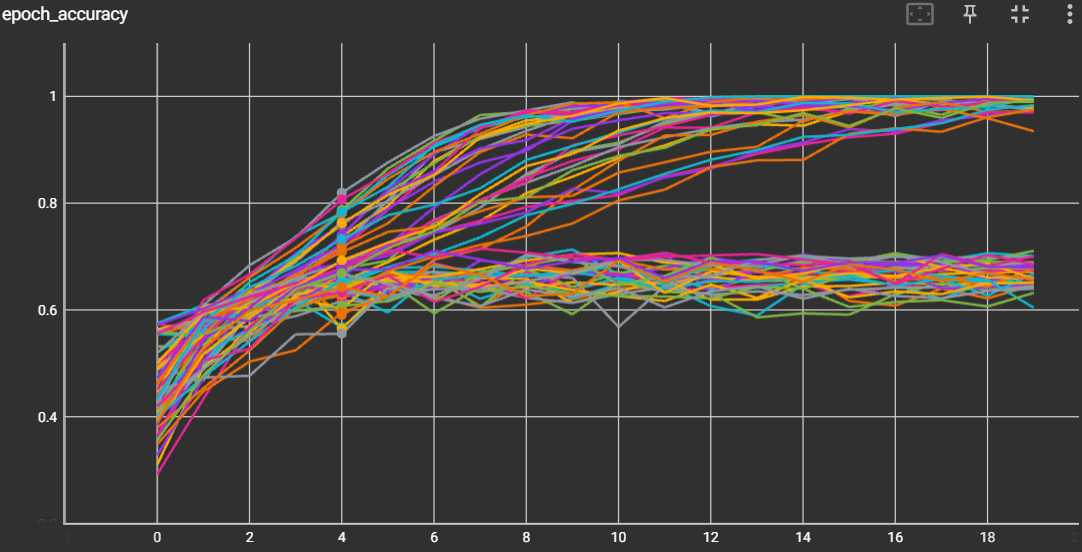

The accuracy is 1 after enough epochs, but that only means that the model might have overfit. That is the reason why, in order to choose the best model, we need to focus on the validation loss.


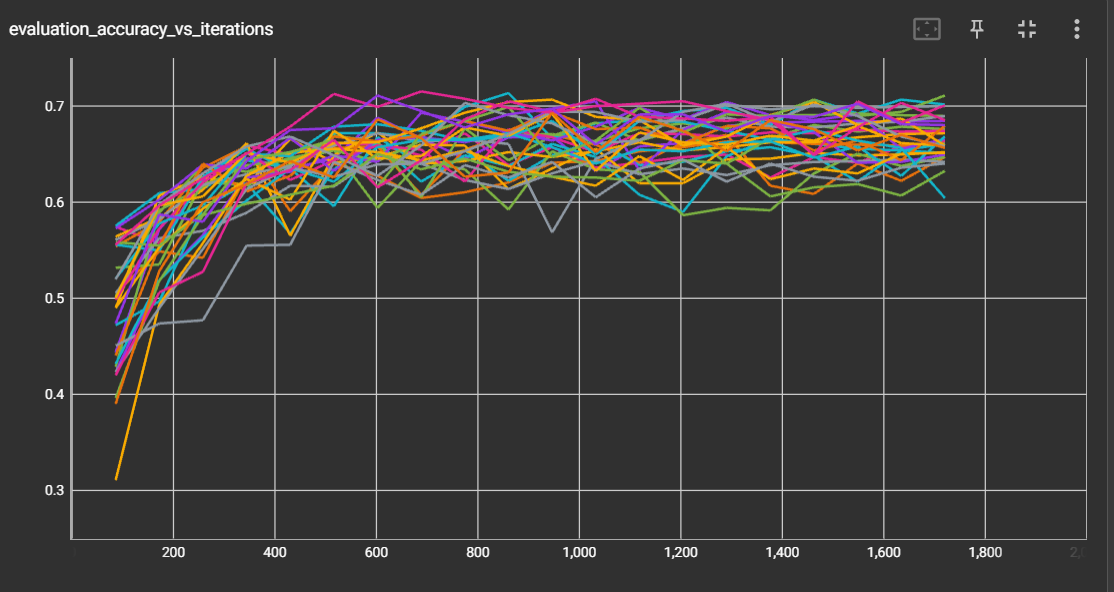

The graph above showcases the accuracy of the model on the validation set, it peaks at 71% on the model that has 4 convolutional layer, 64 nodes and 1 dense layer. after the 6th epochs, the model seems to not increase much in accuracy so 8 epochs seems to be the safest choice.


![image.png](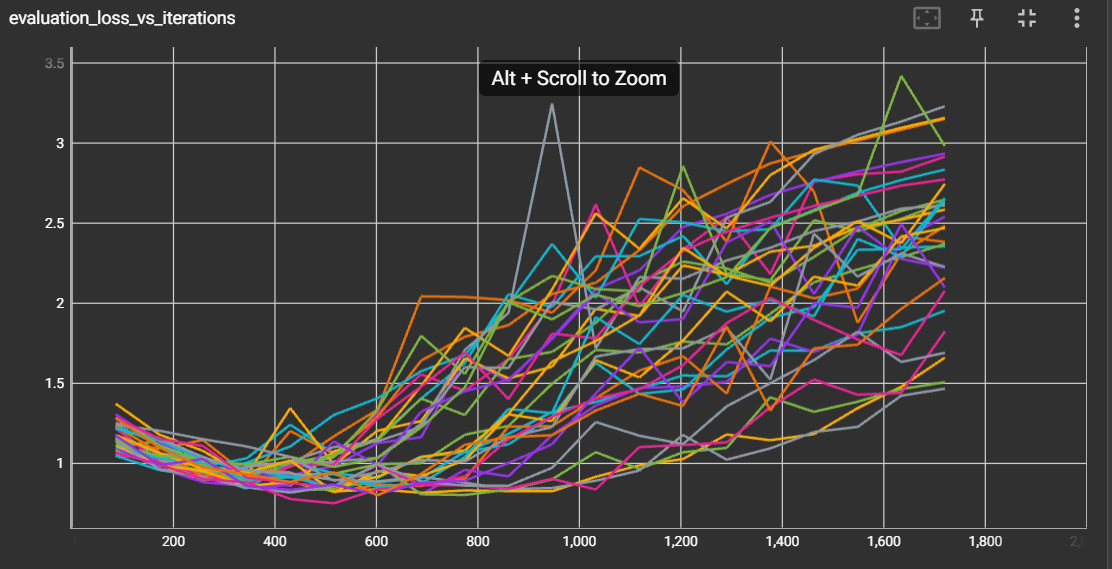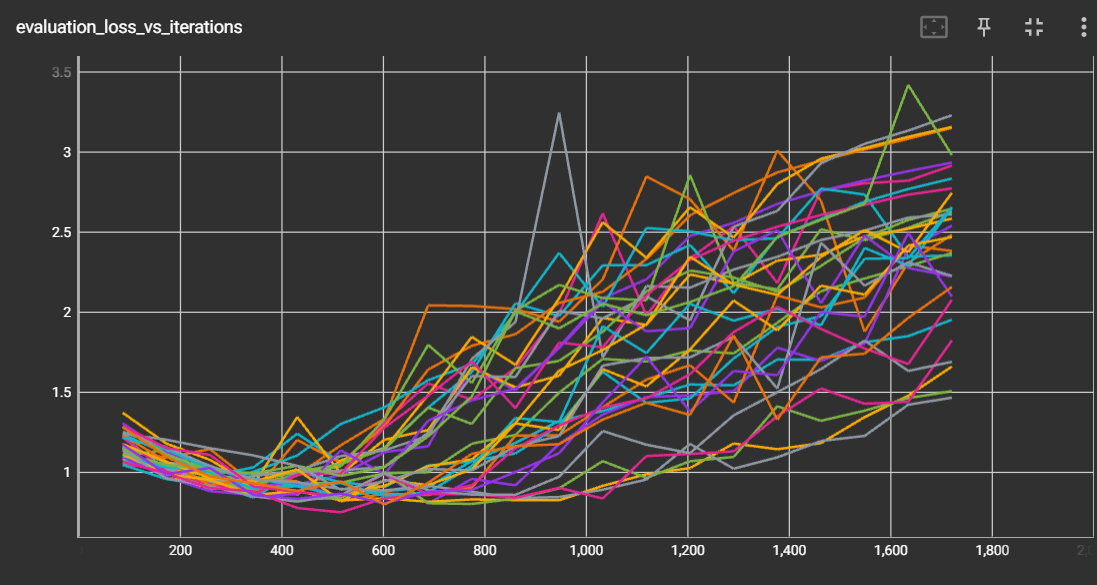)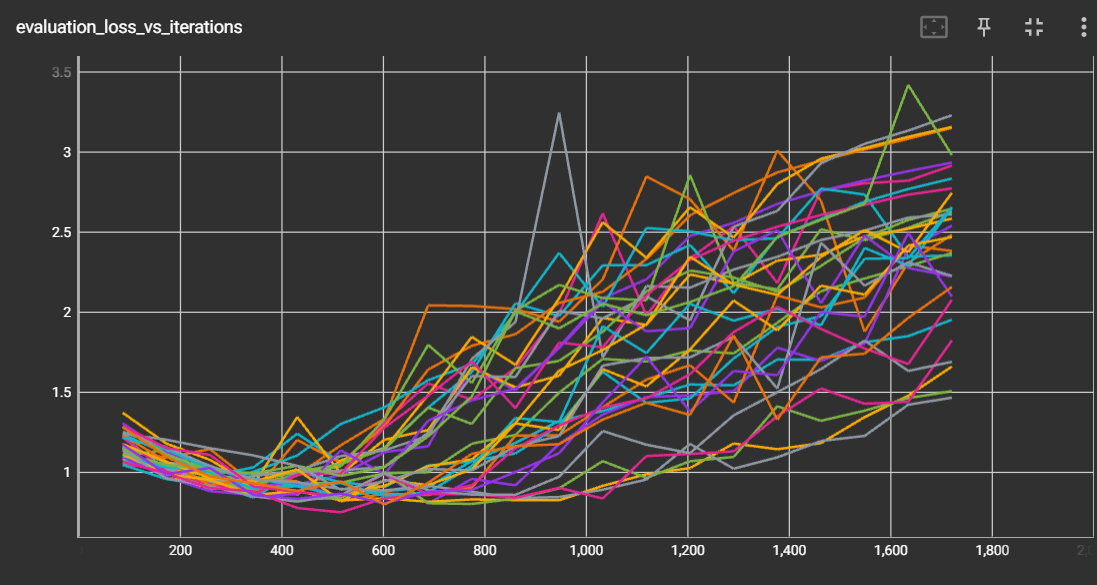

The graph above (Validation Loss) confirms the accuracy of the previous graph. at the 6th epoch, the model reaches the minimum validation loss.

In [ ]:


dense_layers = [1]
layer_sizes = [64]
conv_layers = [4]


for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X_train.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(len(CATEGORIES)))
            model.add(Activation('softmax'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='sparse_categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'])

            model.fit(X_train, y_train,
                      batch_size=32,
                      epochs=6,
                      validation_split=0.3,
                      callbacks=[tensorboard])

###Model evaluation

In [ ]:
model.summary()

In [ ]:
y_pred=[]
max_value=0
pos=0
for i in prediction:
  max_value=0
  pos=0
  for a in range(len(prediction[0])):
    if i[a]>max_value:
      max_value=i[a]
      pos=a
      print(max_value)
      print(pos)
  print("----------------------")
  y_pred.append(pos)

In [ ]:
y_pred = np.array(y_pred)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique classes
classes = np.unique(np.concatenate((y_test, y_pred)))

# Create a figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Create the heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)  # Set tick labels based on unique classes
ax.yaxis.set_ticklabels(classes)  # Set tick labels based on unique classes

# Rotate tick labels if needed
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Adjust layout to make room for tick labels
plt.tight_layout()

# Display the plot
plt.show()

The class's labels are:


*   0 : Vincent Van Gogh
*   1 : Claude Monet
*   2 : Pablo Picasso
*   3 : Pierre-Auguste Renoir





In [ ]:
print(classification_report(y_pred,y_test))

In [ ]:
mispredictions=y_pred!=y_test

In [ ]:
for i in X_test[mispredictions]:
  plt.imshow(i)
  plt.axis('off')
  plt.show()